In [1]:
# Name: Abdullahi Sani Shuaibu
# ID: 202303370
# Project: Embedded Markov Proces based Model for Performance Analysis of IDPS 
# Course: COE 520 (Queuing Theory and Network Applications)
# Instructor: Dr. Mohammad Abdurazzak Felemban
# Term: 231
# Date: 6 October, 2023

### Constants

In [2]:
L = 10 # L-1 is queue length
L_list = [3, 5, 10, 20]
# L_list = [5, 10, 25, 50, 100]
p = 0.3 # probability of early decision
p_list = [0.25, 0.5, 0.75, 0.9]
r = 1 - p # probability of content checking
lams = [lam for lam in range(0, 500, 25)]

### Settings

In [3]:
micro = 10**-6;
# settings  = {
#     1: {'alpha': (1/0.5)*micro, 'mu': (1/4)*micro},
#     2: {'alpha': (1/0.5)*micro, 'mu': (1/8)*micro},
#     3: {'alpha': (1/0.5)*micro, 'mu': (1/12)*micro},
#     4: {'alpha': (1/5.0)*micro, 'mu': (1/12)*micro},
#     }

settings  = {
    1: {'alpha': (0.5)*micro, 'mu': (4)*micro},
    2: {'alpha': (0.5)*micro, 'mu': (8)*micro},
    3: {'alpha': (0.5)*micro, 'mu': (12)*micro},
    4: {'alpha': (5.0)*micro, 'mu': (12)*micro},
    }

### Coefficients

In [4]:
w01 = w02 = 1
w11 = lambda setting, lam: ((setting['alpha'] + lam)*lam)/((setting['alpha'] + p*lam)*setting['mu'])
w12 = lambda setting, lam: (lam - p*lam)/(setting['alpha'] + p*lam)

def wn1(n, setting, lam):
    """ for 2 <= n < L """
    if n == 0:
        return w01
    if n == 1:
        return w11(setting, lam)
    return (((setting['alpha'] + lam)*(lam + setting['mu']))/((p*lam + setting['alpha'])*setting['mu']))*wn1(n-1, setting, lam) - ((lam + setting['alpha'])/(lam*p + setting['alpha']))*wn1(n-2, setting, lam) - ((lam*setting['alpha'])/((lam*p + setting['alpha'])*setting['mu']))*wn2(n-1, setting, lam)

def wn2(n, setting, lam):
    """ for 2 <= n < L """
    if n == 0:
        return w02
    if n == 1:
        return w12(setting, lam)
    return (lam/(lam + setting['alpha']))*wn2(n-1, setting, lam) + (((1 - p)*setting['mu'])/(lam + setting['alpha']))*wn1(n, setting, lam)

# print(wn1(15, settings[1], 5))
# print(wn2(15, settings[1], 5))

### Probabilities

In [5]:
q00 = lambda setting, lam, L=L: 1/(1 + sum([wn1(n, setting, lam) + wn2(n, setting, lam) for n in range(1, L+1)]))

def qn1(n, setting, lam, L=L, p=p): # p not needed
    if n == L and L > 1:
        return ((lam)/(setting['mu']))*wn1(L-1, setting, lam)*q00(setting, lam, L)
    if n == L and L == 1:
        return ((lam)/(setting['mu']))*q00(setting, lam, L)
    return wn1(n, setting, lam)*q00(setting, lam, L)
    
def qn2(n, setting, lam, L=L, p=p):
    if n == L and L > 1:
        return ((lam)/(setting['alpha']))*(wn2(L-1, setting, lam) + (1-p)*wn1(L-1, setting, lam))*q00(setting, lam, L)
    if n == L and L == 1:
        return ((1-p)*lam)/(setting['alpha'])*q00(setting, lam, L)
    return wn2(n, setting, lam)*q00(setting, lam, L)
    
# print('q00: ', q00(settings[2], 5))
# print('q21: ', qn1(2, settings[2], 5))
# print('q22: ', qn2(2, settings[2], 5))

## Performance Metrices

#### Throughput

In [6]:
def throughput(setting, lam, L=L, p=p):
    return p*setting['mu']*sum([qn1(n, setting, lam, L, p) for n in range(1, L+1)]) + setting['alpha']*sum([qn2(n, setting, lam, L, p) for n in range(1, L+1)])

#### Probability of Packet Loss

In [7]:
def ppl(setting, lam, L=L, p=p):
    return qn1(L, setting, lam, L, p) + qn2(L, setting, lam, L, p)

#### Average Number of Packets in the System

In [8]:
def avgn(setting, lam, L=L, p=p):
    return sum([n*(qn1(n, setting, lam, L, p) + qn2(n, setting, lam, L, p)) for n in range(1, L+1)])

#### Average Packet Time in the System

In [9]:
def avgt(setting, lam, L=L, p=p):
    return avgn(setting, lam, L, p)/throughput(setting, lam, L, p)

#### Average Service Time of the Two Stages

In [10]:
def avgst(setting):
    return (1/setting['mu']) + ((1-p)/setting['alpha'])

#### Average Packet Queue Time

In [11]:
def avgqt(setting, lam, L=L, p=p):
    return avgt(setting, lam, L, p) - avgst(setting)

## Generate Data

In [12]:
import csv
import os
import json

def data_gen(type='settings'):
    data_dir = os.path.join('data', type)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    csv_path = os.path.join(data_dir, type + '.csv')
    json_path = os.path.join(data_dir, type + '.json')
    csv_file= open(csv_path, mode='w')
    json_file= open(json_path, mode='w')
        
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    header = [str(lam) for lam in lams]

    if type == 'settings':
        data = {}
        for setting in settings:
            data[setting] = {}
        for setting in settings:
            for lam in lams:
                this_point = {}
                this_point['throughput'] = throughput(setting=settings[setting], lam=lam)
                this_point['ppl'] = ppl(setting=settings[setting], lam=lam)
                this_point['delay'] = avgt(setting=settings[setting], lam=lam)
                data[setting].update({lam: this_point})

            csv_writer.writerow([f'setting: {setting}'])
            csv_writer.writerow(header)
            throughputs = []
            ppls = []
            delays = []
            for lam in data[setting]:
                throughputs.append(data[setting][lam]['throughput'])
                ppls.append(data[setting][lam]['ppl'])
                delays.append(data[setting][lam]['delay'])
            csv_writer.writerow(throughputs)
            csv_writer.writerow(ppls)
            csv_writer.writerow(delays)
        json.dump(data, json_file)

    if type == 'population':
        data = {}
        for population in L_list:
            data[population] = {}
        for population in L_list:
            for lam in lams:
                this_point = {}
                this_point['throughput'] = throughput(setting=settings[1], lam=lam, L=population)
                this_point['ppl'] = ppl(settings[1], lam, L=population)
                this_point['delay'] = avgt(settings[1], lam, L=population)
                data[population].update({lam: this_point})

            csv_writer.writerow([f'population: {population}'])
            csv_writer.writerow(header)
            throughputs = []
            ppls = []
            delays = []
            for lam in data[population]:
                throughputs.append(data[population][lam]['throughput'])
                ppls.append(data[population][lam]['ppl'])
                delays.append(data[population][lam]['delay'])
            csv_writer.writerow(throughputs)
            csv_writer.writerow(ppls)
            csv_writer.writerow(delays)
        json.dump(data, json_file)

    if type == 'probabilities':
        data = {}
        for prob in p_list:
            data[prob] = {}
        for prob in p_list:
            for lam in lams:
                this_point = {}
                this_point['throughput'] = throughput(setting=settings[1], lam=lam, p=prob)
                this_point['ppl'] = ppl(settings[1], lam, p=prob)
                this_point['delay'] = avgt(settings[1], lam, p=prob)
                data[prob].update({lam: this_point})

            csv_writer.writerow([f'probability: {prob}'])
            csv_writer.writerow(header)
            throughputs = []
            ppls = []
            delays = []
            for lam in data[prob]:
                throughputs.append(data[prob][lam]['throughput'])
                ppls.append(data[prob][lam]['ppl'])
                delays.append(data[prob][lam]['delay'])
            csv_writer.writerow(throughputs)
            csv_writer.writerow(ppls)
            csv_writer.writerow(delays)
        json.dump(data, json_file)

for type in ['settings', 'probabilities', 'population']:
    data_gen(type=type)

# data_gen(type='probabilities')

KeyboardInterrupt: 

## Load Data

In [ ]:
import json
import pandas as pd

# settings
data_json_settings = json.load(open('./data/settings/settings.json', 'r'))
data_csv_settings = pd.read_csv('./data/settings/settings.csv')

# probabilities
data_json_probabilities = json.load(open('./data/probabilities/probabilities.json', 'r'))
data_csv_probabilities = pd.read_csv('./data/probabilities/probabilities.csv')

# population
data_json_population = json.load(open('./data/population/population.json', 'r'))
data_csv_population = pd.read_csv('./data/population/population.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/settings/settings.json'

## Extract Graphable Data

In [ ]:
def extract_data_from_json(data):
    cohort = {
        'throughput': {},
        'ppl': {},
        'delay': {}
    }

    for point in data:
        cohort['throughput'][point] = []
        cohort['ppl'][point] = []
        cohort['delay'][point] = []

    for point in data:
        for lam in data[point]:
            cohort['throughput'][point].append(data[point][lam]['throughput'])
            cohort['ppl'][point].append(data[point][lam]['ppl'])
            cohort['delay'][point].append(data[point][lam]['delay'])

    return cohort

graphable_settings = extract_data_from_json(data=data_json_settings)
graphable_probabilities = extract_data_from_json(data=data_json_probabilities)
graphable_populations = extract_data_from_json(data=data_json_population)
# print(extract_data_from_json(data=data_json_probabilities))

## Visualizations

In [ ]:
import matplotlib.pyplot as plt

### Security Levels (L=25, p=0.3)

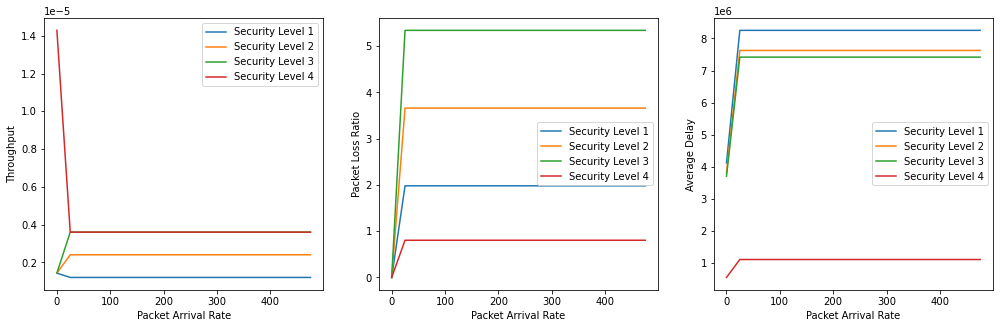

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for setting in graphable_settings['throughput']:
    axs[0].plot(lams, graphable_settings['throughput'][setting], label=f'Security Level {setting}')
    axs[0].legend()
    axs[0].set_ylabel('Throughput')
    axs[0].set_xlabel('Packet Arrival Rate')

for setting in graphable_settings['ppl']:
    axs[1].plot(lams, graphable_settings['ppl'][setting], label=f'Security Level {setting}')
    axs[1].legend()
    axs[1].set_ylabel('Packet Loss Ratio')
    axs[1].set_xlabel('Packet Arrival Rate')

for setting in graphable_settings['delay']:
    axs[2].plot(lams, graphable_settings['delay'][setting], label=f'Security Level {setting}')
    axs[2].legend()
    axs[2].set_ylabel('Average Delay')
    axs[2].set_xlabel('Packet Arrival Rate')

# fig.savefig('./data/graphs/security_levels.jpg')

### Packets in the System

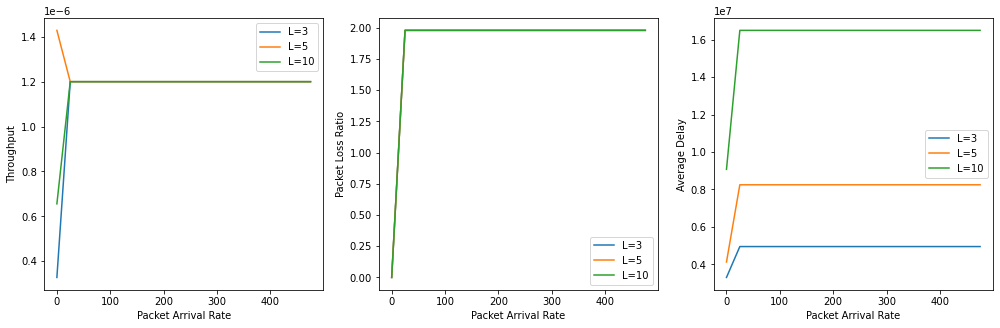

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for population in graphable_populations['throughput']:
    axs[0].plot(lams, graphable_populations['throughput'][population], label=f'L={population}')
    axs[0].legend()
    axs[0].set_ylabel('Throughput')
    axs[0].set_xlabel('Packet Arrival Rate')

for population in graphable_populations['ppl']:
    axs[1].plot(lams, graphable_populations['ppl'][population], label=f'L={population}')
    axs[1].legend()
    axs[1].set_ylabel('Packet Loss Ratio')
    axs[1].set_xlabel('Packet Arrival Rate')

for population in graphable_populations['delay']:
    axs[2].plot(lams, graphable_populations['delay'][population], label=f'L={population}')
    axs[2].legend()
    axs[2].set_ylabel('Average Delay')
    axs[2].set_xlabel('Packet Arrival Rate')

# fig.savefig('./data/graphs/population.jpg')

### Probability of first stage

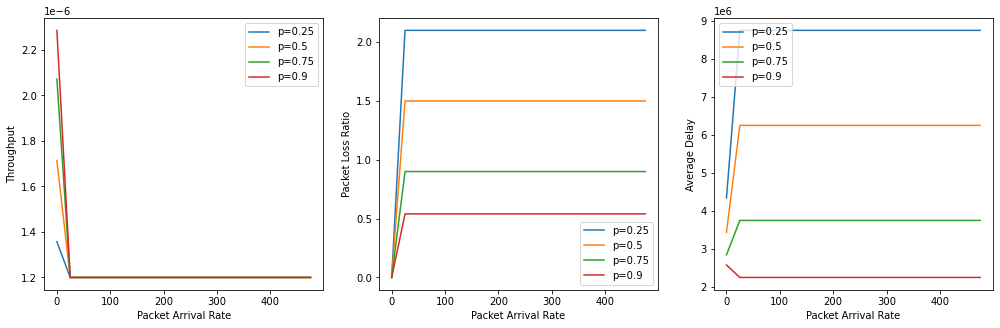

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for probability in graphable_probabilities['throughput']:
    axs[0].plot(lams, graphable_probabilities['throughput'][probability], label=f'p={probability}')
    axs[0].legend()
    axs[0].set_ylabel('Throughput')
    axs[0].set_xlabel('Packet Arrival Rate')

for probability in graphable_probabilities['ppl']:
    axs[1].plot(lams, graphable_probabilities['ppl'][probability], label=f'p={probability}')
    axs[1].legend()
    axs[1].set_ylabel('Packet Loss Ratio')
    axs[1].set_xlabel('Packet Arrival Rate')

for probability in graphable_probabilities['delay']:
    axs[2].plot(lams, graphable_probabilities['delay'][probability], label=f'p={probability}')
    axs[2].legend()
    axs[2].set_ylabel('Average Delay')
    axs[2].set_xlabel('Packet Arrival Rate')

# fig.savefig('./data/graphs/probability.jpg')